# Convolve function

## Scipy

In [1]:
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
from scipy import signal
from scipy.misc import derivative
import matplotlib.pyplot as plt
from pathlib import Path

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

In [2]:
sig = np.repeat([0., 1., 0.], 100)
win = signal.windows.hann(50)
filtered = signal.convolve(sig, win, mode='same') / sum(win)

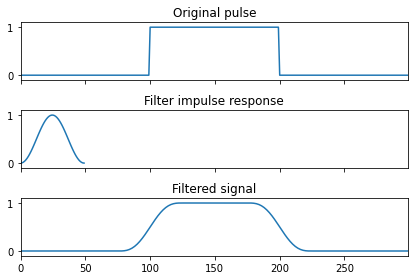

In [3]:
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title("Original pulse")
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title("Filter impulse response")
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title("Filtered signal")
ax_filt.margins(0, 0.1)
fig.tight_layout()

## PyTorch

In [4]:
sig_t = torch.tensor(sig).view(1, 1, -1)
win_t = torch.tensor(win).view(1, 1, -1)

filtered_t = nn.functional.conv1d(sig_t, win_t, padding="same") / win_t.sum()

<ipython-input-4-fda5b68801d8>:4: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  filtered_t = nn.functional.conv1d(sig_t, win_t, padding="same") / win_t.sum()


False


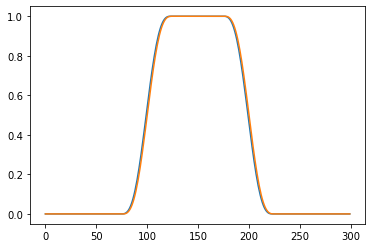

In [5]:
print(np.allclose(filtered_t.squeeze().numpy(), filtered))

plt.plot(filtered_t.squeeze().numpy());
plt.plot(filtered);  # Off by one

# CWT implmentation

Adapted from: https://github.com/nickgeoca/cwt-tensorflow/blob/master/cwt.py

In [6]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

widths = np.arange(1, 31)

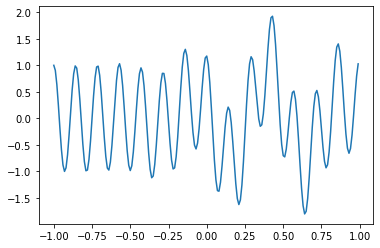

In [7]:
plt.plot(t, sig)

## PyWavelets

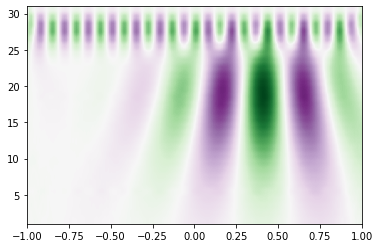

In [8]:
coefs, freqs = pywt.cwt(sig, widths, "mexh")

plt.imshow(
    coefs,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coefs).max(),
    vmin=-abs(coefs).max(),
);

(30, 200)


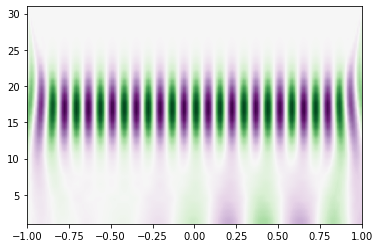

In [9]:
coefs, freqs = pywt.cwt(sig, widths, "cmor1-1", sampling_period=2048)

real, imag = np.real(coefs), np.imag(coefs)
magn = np.sqrt(real ** 2 + imag ** 2)
print(magn.shape)

plt.imshow(
    real,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(real).max(),
    vmin=-abs(real).max(),
);

## Scipy

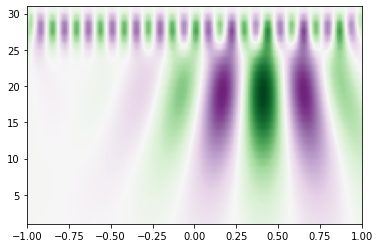

In [10]:
cwtmatr = signal.cwt(sig, signal.ricker, widths)
# cwtmatr = signal.cwt(sig, signal.morlet2, widths)

plt.imshow(
    cwtmatr,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max(),
);

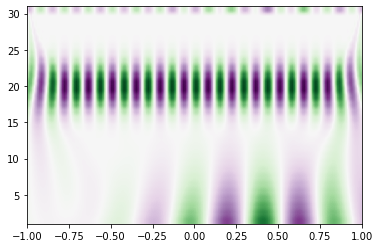

In [11]:
cwtmatr = signal.cwt(sig, signal.morlet2, widths)

real, imag = np.real(cwtmatr), np.imag(cwtmatr)
magn = np.sqrt(real ** 2 + imag ** 2)

plt.imshow(
    real,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(real).max(),
    vmin=-abs(real).max(),
);

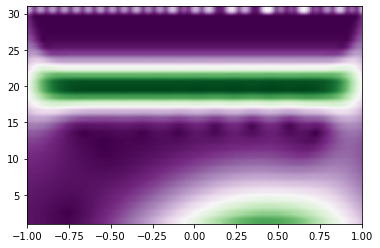

In [12]:
plt.imshow(
    magn,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=magn.max(),
    vmin=magn.min(),
);

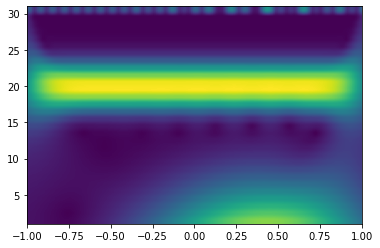

In [13]:
plt.imshow(
    np.absolute(cwtmatr),  # this does the np.sqrt(real ** 2 + imag ** 2)
    extent=[-1, 1, 1, 31],
#     cmap="PRGn",
    aspect="auto",
    vmax=magn.max(),
    vmin=magn.min(),
);

## Raw Numpy

In [14]:
def ricker(points, a):
    A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
    wsq = a**2
    vec = np.arange(0, points) - (points - 1.0) / 2
    xsq = vec**2
    mod = (1 - xsq / wsq)
    gauss = np.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return total

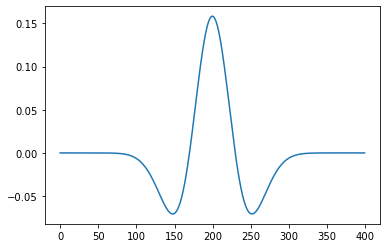

In [15]:
vec = ricker(400, 30)
plt.plot(vec);

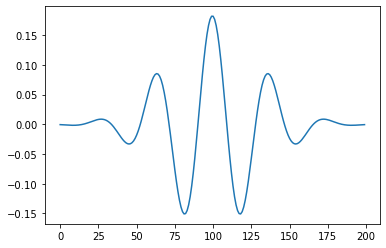

In [16]:
def morlet(M, s):
    x = np.arange(0, M) - (M - 1.0) / 2
    x = x / s
    wavelet = np.exp(-1. * x ** 2. / 2.) * np.cos(5. * x)
    output = np.sqrt(1/s) * wavelet
    return output

vec = morlet(200, 30)
plt.plot(vec);

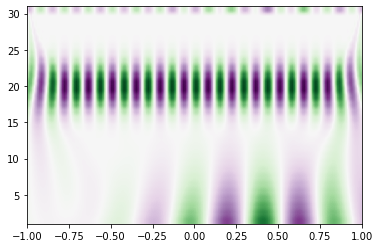

In [17]:
data = sig
# wavelet = ricker
wavelet = morlet
dtype = None
kwargs = {}

# Determine output type
if dtype is None:
    if np.asarray(wavelet(1, widths[0], **kwargs)).dtype.char in 'FDG':
        dtype = np.complex128
    else:
        dtype = np.float64

output = np.empty((len(widths), len(data)), dtype=dtype)
for ind, width in enumerate(widths):
    N = np.min([10 * width, len(data)])
    wavelet_data = np.conj(wavelet(N, width, **kwargs)[::-1])
    output[ind] = signal.convolve(data, wavelet_data, mode='same')
    
    
plt.imshow(
    output,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(output).max(),
    vmin=-abs(output).max(),
);

# Raw Numpy using 2D conv

(200, 1) (30, 2000)
(30, 200)


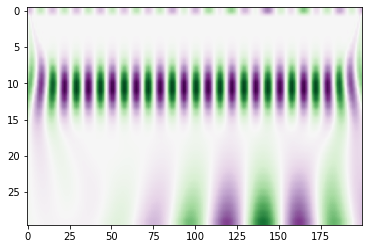

In [18]:
wavelet_bank = [np.conj(wavelet(len(data) * 10, w, **kwargs)[::-1]) for w in widths]  # (2000, 30)
# wavelet_bank = [np.conj(wavelet(len(data), w, **kwargs)[::-1]) for w in widths]  # (200, 30)

wavelet_bank = np.stack(wavelet_bank)

print(data.reshape(-1, 1).shape, wavelet_bank.shape)

output = signal.convolve(data.reshape(-1, 1), wavelet_bank.T) #, mode='same')

mid_point = output.shape[0] // 2
crop_start = mid_point - data.shape[0] // 2
crop_end = mid_point + data.shape[0] // 2
output = output[crop_start:crop_end].T

# output = np.empty((len(widths), len(data)), dtype=dtype)
# for ind, wv in enumerate(wavelet_bank):
#     output[ind] = signal.convolve(data, wv, mode='same')
    
print(output.shape)
    
plt.imshow(
    output,
#     extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(output).max(),
    vmin=-abs(output).max(),
);

## PyTorch

In [19]:
def ricker_pt(points, a):
    A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
    wsq = a**2
    vec = torch.arange(0, points) - (points - 1.0) / 2
    xsq = vec**2
    mod = (1 - xsq / wsq)
    gauss = torch.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return total

torch.Size([32, 3, 200]) torch.Size([32, 3, 30, 200])


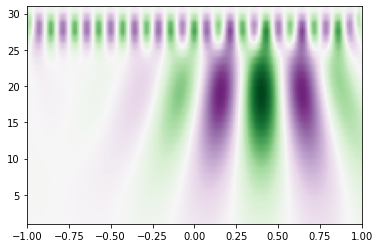

In [20]:
# 1D conv
wavelet = ricker_pt

data_pt = torch.tensor(data, dtype=torch.float32)
data_pt = torch.stack([data_pt] * 3)  # 3 channels
data_pt = torch.stack([data_pt] * 32)  # Batch of 32

bs = data_pt.shape[0]
ch = data_pt.shape[1]
# t = data_pt.shape[2]

output = []
for ind, width in enumerate(widths):
    N = np.min([10 * width, len(data)])
    wavelet_data = torch.conj(torch.flip(wavelet(N, width, **kwargs), [-1]))    
    wavelet_data = torch.broadcast_to(wavelet_data, (ch, ch, wavelet_data.shape[0]))
    output.append(nn.functional.conv1d(data_pt, wavelet_data, padding="same"))
    
    
output = torch.stack(output, 2)

print(data_pt.shape, output.shape)
    
plt.imshow(
    output[0, 0].numpy(),
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(output).max(),
    vmin=-abs(output).max(),
);

Input shape: torch.Size([32, 1, 3, 200])
(30, 200)
Wavelet bank: torch.Size([30, 1, 3, 200])
torch.Size([32, 30, 3, 200])
torch.Size([30, 200])


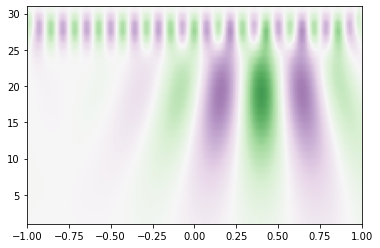

In [21]:
# 2D conv
n_channels = 3

wavelet = ricker
wavelet_bank = [np.conj(wavelet(len(data), w, **kwargs)[::-1]) for w in widths]  # (200, 30)
wavelet_bank = np.stack(wavelet_bank)

data_pt = torch.tensor(data, dtype=torch.float32)
data_pt = torch.stack([data_pt] * n_channels)  # 3 channels
data_pt = torch.stack([data_pt] * 32)  # Batch of 32
print("Input shape:", data_pt.unsqueeze(1).shape)
print(wavelet_bank.shape)
wavelet_bank_pt = torch.tensor(wavelet_bank).view(
    wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
)
wavelet_bank_pt = torch.cat([wavelet_bank_pt] * n_channels, 2).to(dtype=torch.float32)
print("Wavelet bank:", wavelet_bank_pt.shape)

output = nn.functional.conv2d(data_pt.unsqueeze(1), wavelet_bank_pt, padding="same")
# output = nn.functional.conv2d(data_pt.unsqueeze(1), wavelet_bank_pt)
print(output.shape)
print(output[0, :, 0].shape)


plt.imshow(
    output[0, :, 0].squeeze().numpy(),
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(output).max(),
    vmin=-abs(output).max(),
);

## PyTorch Module

torch.Size([32, 3, 30, 200])


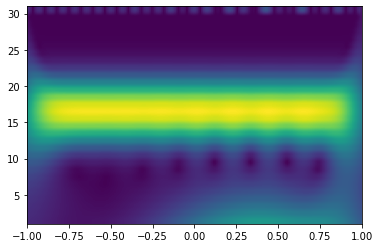

In [22]:
class CWT(nn.Module):
    def __init__(self, widths, wavelet="ricker", filter_len=2000, channels=3, dt=1/2048):
        super().__init__()
        self.widths = widths
        self.scales = None
        self.wavelet = getattr(self, wavelet)
        self.filter_len = filter_len
        self.channels = channels
        self.dt = dt
        self.dj = 0.125
        self.w0 = 6
        self.stride = (1, 1)
        self.wavelet_bank = self._build_wavelet_bank()

    def ricker(self, points, a):
        # https://github.com/scipy/scipy/blob/v1.7.1/scipy/signal/wavelets.py#L262-L306
        A = 2 / (np.sqrt(3 * a) * (np.pi ** 0.25))
        wsq = a ** 2
        vec = torch.arange(0, points) - (points - 1.0) / 2
        xsq = vec ** 2
        mod = 1 - xsq / wsq
        gauss = torch.exp(-xsq / (2 * wsq))
        total = A * mod * gauss
        return total

    def morlet(self, points, s):
        x = torch.arange(0, points) - (points - 1.0) / 2
        x = x / s
        # https://uk.mathworks.com/help/wavelet/ref/morlet.html
        wavelet = torch.exp(-(x ** 2.0) / 2.0) * torch.cos(5.0 * x)
        output = np.sqrt(1 / s) * wavelet
        return output
    
    def cmorlet(self, points, s, wavelet_width=1, center_freq=1):
        # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
        x = torch.arange(0, points) - (points - 1.0) / 2
        x = x / s
        norm_constant = np.sqrt(np.pi * wavelet_width)
        exp_term = torch.exp(-(x ** 2) / wavelet_width)
        kernel_base = exp_term / norm_constant
        kernel = kernel_base * torch.exp(1j * 2 * np.pi * center_freq * x)
        return kernel
    
#     def cmorlet(M, scale=1.0, complete=True):
#         M = 10 * scale / self.dt
#         t = torch.arange((-M + 1) / 2., (M + 1) / 2.) * self.dt
#         if len(t) % 2 == 0: t = t[0:-1]
#         norm = (dt / scale) ** .5
#         x = t / scale
#         output = torch.exp(1j * self.w0 * x)

#         if complete:
#             output -= np.exp(-0.5 * (self.w0 ** 2))

#         output *= torch.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)
#         return norm * output
    
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)
    
    def cgaussian(self, M, s, order=1, norm_constant=1):
        # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
        x = np.arange(0, M) - (M - 1.0) / 2
        x = x / s

        def gaus(x):
            term_1 = np.exp(-1j * x)
            term_2 = np.exp(-x**2)
            return norm_constant * term_1 * term_2

        out = torch.tensor([derivative(gaus, x_i, n=order) for x_i in x])
        return out.to(dtype=torch.complex64)
    
    
    def _build_wavelet_bank(self):
        wavelet_bank = [torch.conj(torch.flip(self.wavelet(self.filter_len, w), [-1])) for w in self.widths]
        wavelet_bank = torch.stack(wavelet_bank)
        wavelet_bank = wavelet_bank.view(wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1])
        wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        return wavelet_bank
        
    def forward(self, x):
               
        if self.wavelet_bank.is_complex():
            output_real = nn.functional.conv2d(x.unsqueeze(1), self.wavelet_bank.real, padding="same", stride=self.stride)
            output_imag = nn.functional.conv2d(x.unsqueeze(1), self.wavelet_bank.imag, padding="same", stride=self.stride)
            output_real = torch.transpose(output_real, 1, 2)
            output_imag = torch.transpose(output_imag, 1, 2)
            return torch.complex(output_real, output_imag)
        else:
            output = nn.functional.conv2d(x.unsqueeze(1), self.wavelet_bank, padding="same", stride=self.stride)
            return torch.transpose(output, 1, 2)
    
    
# pycwt = CWT(widths, "morlet", 2000, 3)
# out = pycwt(data_pt)
# print(out.shape)

# plt.imshow(
#     out[0, 0].numpy(),
#     extent=[-1, 1, 1, 31],
#     cmap="PRGn",
#     aspect="auto",
#     vmax=abs(out).max(),
#     vmin=-abs(out).max(),
# );


pycwt = CWT(widths, "cmorlet", 2000, 3)
out = pycwt(data_pt)
print(out.shape)

mag = torch.absolute(out)

plt.imshow(
    mag[0, 0].numpy(),
    extent=[-1, 1, 1, 31],
#     cmap="PRGn",
    aspect="auto",
    vmax=mag[0, 0].max(),
    vmin=mag[0, 0].min(),
);

# Port TensorFlow CWT

https://github.com/Kevin-McIsaac/cmorlet-tensorflow/blob/master/CWT/cwt.py

https://github.com/Kevin-McIsaac/cmorlet-tensorflow/blob/master/cwt_demo.ipynb

In [23]:
# Parameters CWT
lower_freq = 35
upper_freq = 350
n_scales = 32
wavelet_width = 1
size_factor = 1


initial_wavelet_width = wavelet_width
fs = 2048
# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
# Generate the frequency range
frequencies = 1 / scales

In [24]:
def _build_wavelet_bank():
    # Generate the wavelets
    # We will make a bigger wavelet in case the width grows
    # For the size of the wavelet we use the initial width value.
    # |t| < truncation_size => |k| < truncation_size * fs
    truncation_size = scales.max() * np.sqrt(4.5 * initial_wavelet_width) * fs
    one_side = int(size_factor * truncation_size)
    kernel_size = 2 * one_side + 1
    k_array = np.arange(kernel_size, dtype=np.float32) - one_side
    t_array = k_array / fs  # Time units
    
    # Wavelet bank shape: 1, kernel_size, 1, n_scales
    wavelet_bank_real = []
    wavelet_bank_imag = []
    
    for scale in scales:
        norm_constant = np.sqrt(np.pi * wavelet_width) * scale * fs / 2.0
        scaled_t = t_array / scale
        exp_term = np.exp(-(scaled_t ** 2) / wavelet_width)
        kernel_base = exp_term / norm_constant
        kernel_real = kernel_base * np.cos(2 * np.pi * scaled_t)
        kernel_imag = kernel_base * np.sin(2 * np.pi * scaled_t)
        wavelet_bank_real.append(kernel_real)
        wavelet_bank_imag.append(kernel_imag)
        
    # Stack wavelets (shape = kernel_size, n_scales)
    wavelet_bank_real = np.stack(wavelet_bank_real, -1)
    wavelet_bank_imag = np.stack(wavelet_bank_imag, -1)
    
    return wavelet_bank_real, wavelet_bank_imag

    
real, imag = _build_wavelet_bank()

In [25]:
real.shape

(249, 32)

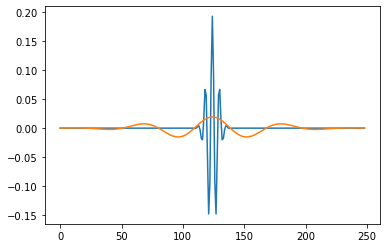

In [26]:
plt.plot(real[:, 0]);
plt.plot(real[:, 31]);

In [27]:
output_real = signal.convolve(data.reshape(-1, 1), real) # , mode='same')
output_imag = signal.convolve(data.reshape(-1, 1), -imag) # , mode='same')

scalogram_magn = np.sqrt(output_real ** 2 + output_imag ** 2)

mid_point = output_real.shape[0] // 2
crop_start = mid_point - data.shape[0] // 2
crop_end = mid_point + data.shape[0] // 2

output_real = output_real[crop_start:crop_end].T
output_imag = output_imag[crop_start:crop_end].T
scalogram_magn = scalogram_magn[crop_start:crop_end].T

output_real.shape, output_imag.shape

((32, 200), (32, 200))

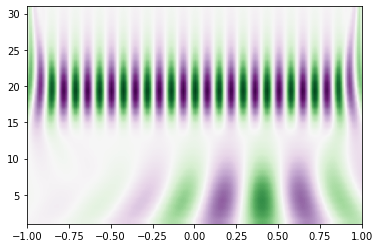

In [28]:
plt.imshow(
    output_real,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(scalogram_magn).max(),
    vmin=-abs(scalogram_magn).max(),
);

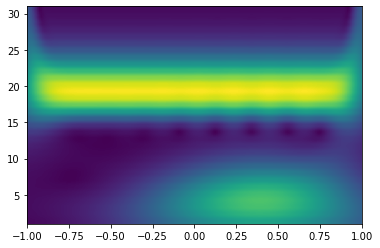

In [29]:
plt.imshow(
    scalogram_magn,
    extent=[-1, 1, 1, 31],
    aspect="auto",
    vmax=scalogram_magn.max(),
    vmin=scalogram_magn.min(),
);

# Complex Morlet

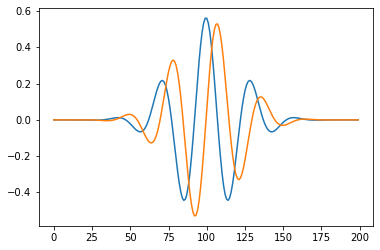

In [30]:
def cmorlet(M, s, wavelet_width=1, center_freq=1):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    x = np.arange(0, M) - (M - 1.0) / 2
    x = x / s
    norm_constant = np.sqrt(np.pi * wavelet_width)
    exp_term = np.exp(-(x ** 2) / wavelet_width)
    kernel_base = exp_term / norm_constant
    kernel = kernel_base * np.exp(1j * 2 * np.pi * center_freq * x)
    return kernel

vec = cmorlet(200, 30)
plt.plot(np.real(vec))
plt.plot(np.imag(vec));

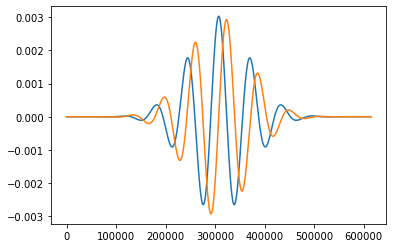

In [31]:
# https://github.com/Anjum48/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py
def morlet_v2(M, scale=1.0, complete=True, dt=1/2048, w0=6):
    # Number of points needed to capture wavelet
    M = 10 * scale / dt
    # Times to use, centred at zero
    t = np.arange((-M + 1) / 2., (M + 1) / 2.) * dt
    if len(t) % 2 == 0: t = t[0:-1]  # requires odd filter size
    # Sample wavelet and normalise
    norm = (dt / scale) ** .5
    x = t / scale
    output = np.exp(1j * w0 * x)

    if complete:
        output -= np.exp(-0.5 * (w0 ** 2))

    output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)
    return norm * output


vec = morlet_v2(200, 30)
plt.plot(np.real(vec))
plt.plot(np.imag(vec));

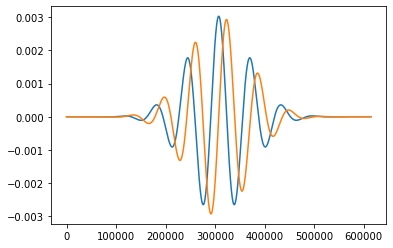

In [32]:
def cmorlet_pt(M, s, wavelet_width=1, center_freq=1):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    x = torch.arange(0, M) - (M - 1.0) / 2
    x = x / s
    norm_constant = np.sqrt(np.pi * wavelet_width)
    exp_term = torch.exp(-(x ** 2) / wavelet_width)
    kernel_base = exp_term / norm_constant
    kernel = kernel_base * torch.exp(1j * 2 * np.pi * center_freq * x)
    return kernel


def morlet_pt_v2(M, scale=1.0, complete=True, dt=1/2048, w0=6):
    M = 10 * scale / dt
    t = torch.arange((-M + 1) / 2., (M + 1) / 2.) * dt
    if len(t) % 2 == 0: t = t[0:-1]
    norm = (dt / scale) ** .5
    x = t / scale
    output = torch.exp(1j * w0 * x)

    if complete:
        output -= np.exp(-0.5 * (w0 ** 2))

    output *= torch.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)
    return norm * output

vec = morlet_pt_v2(200, 30)
plt.plot(torch.real(vec).numpy())
plt.plot(torch.imag(vec).numpy());

In [33]:
vec.dtype

torch.complex64

# Complex Gaussian

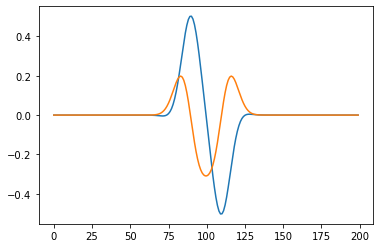

In [34]:
def cgaussian(M, s, order=1, norm_constant=1):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    x = np.arange(0, M) - (M - 1.0) / 2
    x = x / s
    
    def gaus(x):
        return norm_constant * np.exp(-1j * x) * np.exp(-x**2)
    
    out = np.array([derivative(gaus, x_i, n=order) for x_i in x])
    return out


vec = cgaussian(200, 10, 1)
plt.plot(np.real(vec))
plt.plot(np.imag(vec));

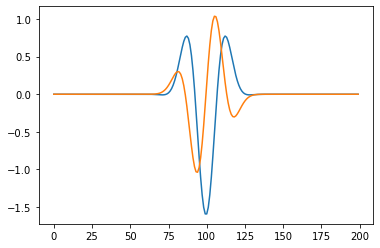

In [35]:
def cgaussian_pt(M, s, order=1, norm_constant=1):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    x = np.arange(0, M) - (M - 1.0) / 2
    x = x / s
    
    def gaus(x):
        return norm_constant * np.exp(-1j * x) * np.exp(-x**2)
    
    out = torch.tensor([derivative(gaus, x_i, n=order) for x_i in x])
    return out.to(torch.complex64)


vec = cgaussian_pt(200, 10, 2)
plt.plot(torch.real(vec).numpy())
plt.plot(torch.imag(vec).numpy());

# Test with GW data

In [36]:
df = pd.read_csv(INPUT_PATH / "training_labels.csv")

In [37]:
def load_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
    # return waves / np.max(waves, axis=1).reshape(3, 1)
    return waves / np.max(waves)


# https://www.kaggle.com/kevinmcisaac/g2net-spectral-whitening
def apply_whiten(signal, window=False):  # signal is a numpy array
    
    signal = torch.from_numpy(signal).float()
    
    if signal.ndim == 2:
        win_length = signal.shape[1]
    else:
        win_length = signal.shape[0]
    
    # Not needed if a window has already been applied. Tukey is probably better
    if window:    
        hann = torch.hann_window(win_length, periodic=True, dtype=float)
        signal *= hann
        
    spec = fft(signal)
    mag = torch.sqrt(torch.real(spec * torch.conj(spec)))
    return torch.real(ifft(spec / mag)).numpy() * np.sqrt(win_length / 2)


# Cell 33 of https://www.gw-openscience.org/LVT151012data/LOSC_Event_tutorial_LVT151012.html
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def apply_bandpass(x, lf=25, hf=500, order=4, sr=2048):
#     sos = signal.butter(order, [lf * 2.0 / sr, hf * 2.0 / sr], btype="bandpass", output="sos")
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization

In [38]:
# wave_id = "098a464da9"  # Super clean signal
wave_id = "000a5b6e5c"
# wave_id = "00000e74ad"
# wave_id = "00001f4945"  # target = 0
# wave_id = "0000661522"  # target = 0
# wave_id = "0000a38978"

In [39]:
x = load_file(wave_id)
x *= signal.tukey(4096, 0.2)
x = apply_bandpass(x, 35, 350)
x.shape

(3, 4096)

In [40]:
x_ten = torch.tensor(x, dtype=torch.float32).view(1, 3, 4096)

torch.Size([1, 3, 128, 4096])
tensor(5.2892e-07) tensor(0.5249)


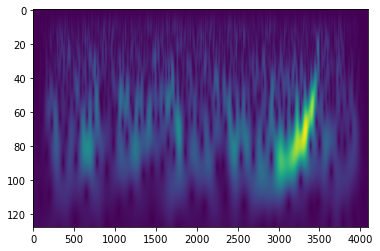

In [41]:
widths = np.linspace(start=2, stop=10, num=128) ** 2  # step=2

pycwt = CWT(widths, "cmorlet", 4096, 3)
out = pycwt(x_ten)
print(out.shape)

mag = torch.absolute(out)

print(mag.min(), mag.max())

plt.imshow(mag[0, 0].numpy(), aspect="auto");

In [42]:
# Thinned data
# print(mag[0, 0, :, ::8].shape)
# plt.imshow(mag[0, 0, :, ::8].numpy(), aspect="auto")

In [43]:
# widths = np.linspace(start=2, stop=10, num=128) ** 2  # step=2

# pycwt = CWT(widths, "cgaussian", 4096, 3)
# out = pycwt(x_ten)
# print(out.shape)

# mag = torch.absolute(out)

# plt.imshow(
#     mag[0, 0].numpy(),
#     aspect="auto",
# );

In [44]:
list(pycwt.parameters())

[]

# PyTorchWavelets

In [45]:
from wavelets_pytorch.transform import WaveletTransformTorch

ImportError: cannot import name 'factorial' from 'scipy.misc' (/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/scipy/misc/__init__.py)

In [ ]:
dt = 1/2048      # sampling frequency
dj = 0.125      # scale distribution parameter

In [ ]:
wa_torch = WaveletTransformTorch(dt, dj)

In [ ]:
cwt_torch = wa_torch.cwt(x_ten.squeeze().numpy())
print(cwt_torch.shape)
cwt_torch = np.abs(cwt_torch)

In [ ]:
cwt_torch.shape

In [ ]:
plt.imshow(
    cwt_torch[0],
#     cwt_torch[0, 10:45],
    aspect="auto",
    vmax=cwt_torch[0].max(),
    vmin=cwt_torch[0].min(),
);